<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code implements a bifurcation analysis of the flux ratio to investigate the influence of fixed charges on ionic transport phenomena.

In Python, `root` is a function from the `scipy.optimize` module that is used to find the roots of a system of nonlinear equations. It is a general-purpose function that can be used to solve various types of equations.

The `root` function has several optional parameters, including `x0` (initial guess) and `method` (solver method). The `method` parameter specifies the algorithm to be used for solving the equations. The default value for `method` is 'hybr'.

'hybr' is short for "hybrid" and it refers to a solver that combines a modified Powell's method with a dogleg trust-region method. This method is suitable for systems of equations where the Jacobian matrix is not provided or is approximated numerically. It is a good choice for general-purpose root finding problems.

Other available options for the `method` parameter in `root` include:

- 'lm': Levenberg-Marquardt algorithm, suitable for least-squares problems.
- 'broyden1' and 'broyden2': Broyden's first and second methods, respectively, for solving systems of equations.
- 'anderson': Anderson's mixing method, suitable for solving systems of equations with good initial guesses.
- 'linearmixing': Linear mixing method, suitable for solving systems of linear equations.

The choice of the solver method depends on the specific characteristics of the problem you are trying to solve. Some methods may be more efficient or accurate for certain types of equations or initial conditions. It is recommended to consult the documentation of `scipy.optimize.root` or the scipy documentation for more details on the available methods and their best use cases.

In [2]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def equations(x):
    A, I, V, l = x

    k = 1
    r = 2
    eps = 1e-15 #  a small number

    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+(l-A+r)**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( (l-A+r)*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*(l-A+r) , eps)/ np.maximum(A, eps) ) # not a real number
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    numI1   = (( (-1)**(k+1) )*siglog) * (A-l)**2
    numI2   = (logAB - ((-1)**k) * np.log( np.maximum(sigma, eps) ))*(A-l+eps)
    gamma1  = 1/(I-(A-l) * sqA)
    gamma2  = 1/(I-(A-l) * sqB)
    M       = I * (gamma2 - gamma1)+ rho/I
    ABGamma = A * gamma1 + (l-A+r) * gamma2
    ABGammaR= (1/A) * gamma1 + (1/(l-A+r)) * gamma2
    G41     = ( 1- (A-l)*ABGamma )*( logSBA + (A-l) * siglog )
    G42     = ( 1- (A-l)*ABGamma )* M
    G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
    GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR



    f1 = rho - (I* ( np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  ))
    f2 = V - logAB + ((I*logSBA-rho)/(A-l))
    f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
    f4 = G41 - G42 + G43 - GR

    return [f1, f2, f3, f4]



In [4]:
# set a range of initial values
A_range = np.linspace(0.01, 10, 10)
I_range = np.linspace(-60, 60, 10)
V_range = np.linspace(-80, 80, 10)
l_range = np.linspace(0.01, 10, 10)

r = 2
# Create a boolean mask for the constraint
# The resulting arrays for A_range, I_range, V_range, and L_range
# will only contain values that satisfy the constraint.
# Calculate Am
Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
#mask = ( (I_range > max_expression) | (I_range < min_expression) )  & (A_range > 0) & (A_range <= Am)
mask = ( (I_range > max_expression) | (I_range < min_expression) ) & (np.abs(I_range) > eps) & (A_range > 0) & (A_range <= Am) & (np.abs(l_range-r) > eps)
#mask = ( (I_range > max_expression) | (I_range < min_expression) ) & (I_range != 0) & (A_range > 0) & (A_range <= Am) & (l_range != 2)
#mask = np.logical_and(np.logical_or(I_range > max_expression, I_range < min_expression), np.logical_and(A_range > 0, A_range <= Am))

# Apply the mask to all arrays
A_range = A_range[mask]
I_range = I_range[mask]
V_range = V_range[mask]
l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

import time

# Start the timer
start_time = time.time()

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(sol.x[3]) - np.log(r)) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(sol.x[3]) - np.log(r)  ))

                    mask2 = (lmd1_sol<=lmd2_sol) & (np.abs(sol.x[1]) > eps) & (np.abs(sol.x[3]-r) > eps) #& (sol.x[0] > 0) & (sol.x[0] <= Am)
                    if np.all(mask2): # only append if all elements of mask are True
                      A_sol = np.append(A_sol, sol.x[0])
                      I_sol = np.append(I_sol, sol.x[1])
                      V_sol = np.append(V_sol, sol.x[2])
                      l_sol = np.append(l_sol, sol.x[3])

<ipython-input-3-d3188d2bbfb1>:25: RuntimeWarning: invalid value encountered in double_scalars
  G43     = ( I+ ( ((-1)**k) * (A-l) ) ) * siglog * M/(A-l)
<ipython-input-3-d3188d2bbfb1>:26: RuntimeWarning: divide by zero encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-3-d3188d2bbfb1>:26: RuntimeWarning: invalid value encountered in double_scalars
  GR      =( ( I**2-(A-l)**2 )/(A-l) ) * M * ABGammaR
<ipython-input-3-d3188d2bbfb1>:31: RuntimeWarning: invalid value encountered in double_scalars
  f2 = V - logAB + ((I*logSBA-rho)/(A-l))
<ipython-input-3-d3188d2bbfb1>:32: RuntimeWarning: divide by zero encountered in double_scalars
  f3 = I - ( (numI1 + numI2+rho)/(logSBA + siglog*(A-l))  )
<ipython-input-4-e768df475b15>:63: RuntimeWarning: invalid value encountered in log
  ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))
<ipython-input-4-e768df475b15>:66: RuntimeWarning: invalid value encountered in log
  (np.log(sol.x[3])

In [5]:
# Calculate the time passing
end_time = time.time()
time_passing = end_time - start_time
print("Time passing:", time_passing, "seconds")

Time passing: 121.3691234588623 seconds


In [54]:

print(np.shape(A_sol))
print('A[0:10] = ', A_sol[0:10])
print('min(A) =',np.min(A_sol))
print('max(A) =',np.max(A_sol))
print('The second max of A is =',np.partition(A_sol,-50)[-50:-40])
print('type of A is', type(A_sol))

print(np.shape(l_sol))
print('l[0:10] = ', l_sol[0:10])
print('min(l) =',np.min(l_sol))
print('max(l) =',np.max(l_sol))
print('The second max of l is =',np.partition(l_sol,-550)[-550:-520])
print('type of l is', type(l_sol))

print(np.shape(V_sol))
print('V[0:10] = ', V_sol[0:10])
print('min(V) =',np.min(V_sol))
print('max(V) =',np.max(V_sol))
print('The second max of V is =',np.partition(V_sol,-50)[-50:-40])
print('type of V is', type(V_sol))

print(np.shape(I_sol))
print('I[0:10] = ', I_sol[0:10])
print('min(I) =',np.min(I_sol))
print('max(I) =',np.max(I_sol))
print('The second max of I is =',np.partition(I_sol,-50)[-50:-40])




(2025,)
A[0:10] =  [ 0.4087401   1.21741905 90.26735448  1.88580829  1.91771901 90.26745706
  1.99239684  0.41388522 90.26744174  1.96503958]
min(A) = 0.40874009931267385
max(A) = 90.27358966801124
The second max of A is = [90.26837093 90.26837161 90.2683746  90.26838634 90.26838    90.2683923
 90.26839583 90.26840924 90.26841406 90.26841905]
type of A is <class 'numpy.ndarray'>
(2025,)
l[0:10] =  [  0.40874082   1.21741905 134.73564705   1.88580828   1.91771899
 134.73580086   1.99239683   0.41388523 134.73577789   1.9650399 ]
min(l) = 0.07911307426262439
max(l) = 134.74499580155666
The second max of l is = [  6.67649      6.71419402   6.71426449   6.71431874   6.7143352
   6.71432745   6.71436202   6.71434565   6.71435277   6.71435711
   6.72881373 134.73544551 134.73533377 134.73555303 134.73555223
 134.73518572 134.73521063 134.73564975   6.72892222 134.73519871
 134.73559348   7.36863749 134.73492588 134.73525688 134.7355512
 134.73487479 134.73564261 134.73540079 134.7344565  134

In [7]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

#fig = plt.figure(figsize=(8, 6))
#ax = fig.add_subplot(111, projection='3d')

#ax.scatter(l_sol, V_sol, I_sol, c='red', s=5)
#ax.set_xlabel('l')
#ax.set_ylabel('V')
#ax.set_zlabel('I(current)')
#ax.set_xlim(0, 6)
#ax.set_ylim(-20, 50)
#ax.set_zlim(ymin, ymax)

#plt.show()


In [74]:
r = 2

# Calculate lmd1 and lmd2
lmd1 = 3*(l_sol - A_sol + I_sol) * \
       (np.log(np.maximum(l_sol/r, 1e-15))) / \
       ((l_sol - r) * ( V_sol + np.log(l_sol) - np.log(r)   ))

lmd2 = 3*(l_sol - A_sol - I_sol) * \
       (np.log(np.maximum(l_sol/r, +1e-15))) / \
       ((l_sol - r) * (-V_sol + np.log(l_sol) - np.log(r)   ))

J1 = (l_sol - A_sol + I_sol) /2
J2 = (l_sol - A_sol - I_sol) /2

# Generate t vector
t = np.arange(len(lmd1))

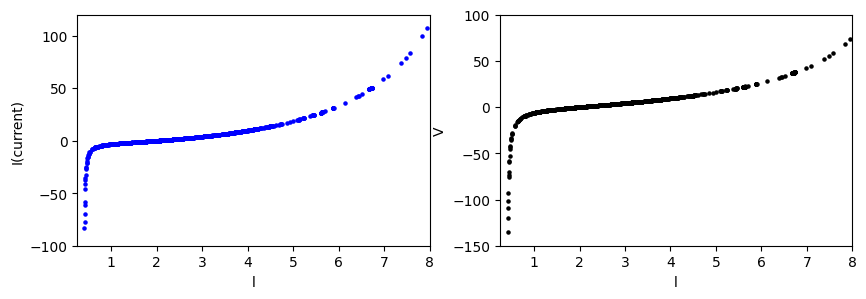

In [73]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)
axs[0, 0].scatter(l_sol, I_sol, s=5, c='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('I(current)')
axs[0,0].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0,0].set_ylim(-100, 120)  # Adjust the y-axis limits

axs[0, 1].scatter(l_sol, V_sol, s=5, c='black')
axs[0, 1].set_xlabel('l')
axs[0, 1].set_ylabel('V')
axs[0,1].set_xlim(0.25, 8)  # Adjust the x-axis limits
axs[0,1].set_ylim(-150, 100)  # Adjust the y-axis limits


plt.show()

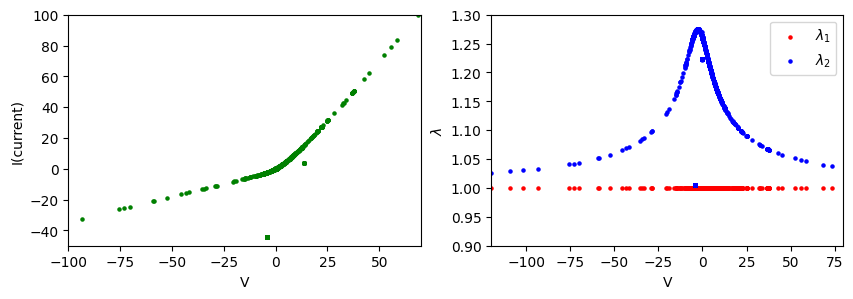

In [72]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(V_sol, I_sol, s=5, c='green')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('I(current)')
axs[0, 0].set_xlim(-100, 70)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 100)  # Adjust the y-axis limits
# Plot lmd1 and lmd2 using scatter plots

axs[0, 1].scatter(V_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 1].scatter(V_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('$\lambda$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 1].set_ylim(0.9, 1.3)  # Adjust the y-axis limits

plt.show()

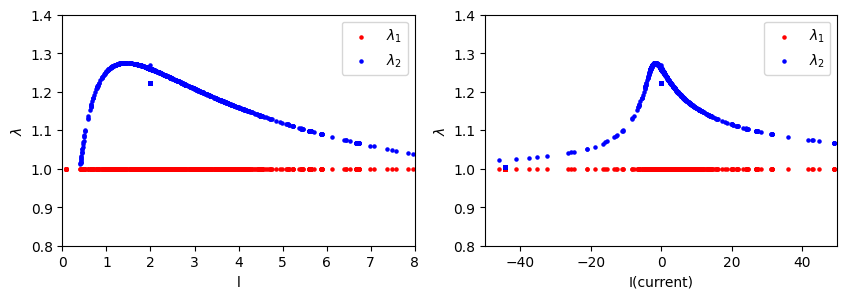

In [77]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(l_sol, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].scatter(l_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('$\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(0, 8)  # Adjust the x-axis limits
axs[0, 0].set_ylim(0.8, 1.4)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('$\lambda$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-50, 50)  # Adjust the x-axis limits
axs[0, 1].set_ylim(0.8, 1.4)  # Adjust the y-axis limits


plt.show()

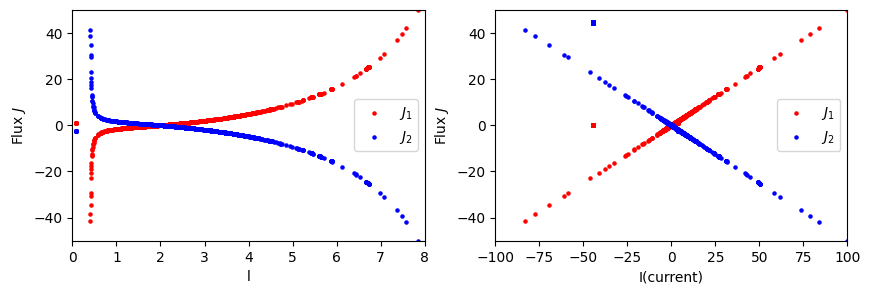

In [76]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(l_sol, J1, label='$J_1$',s=5, color='red')
axs[0, 0].scatter(l_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 0].set_xlabel('l')
axs[0, 0].set_ylabel('Flux $J$')
axs[0, 0].legend()
axs[0, 0].set_xlim(0, 8)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 50)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('Flux $J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-100, 100)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

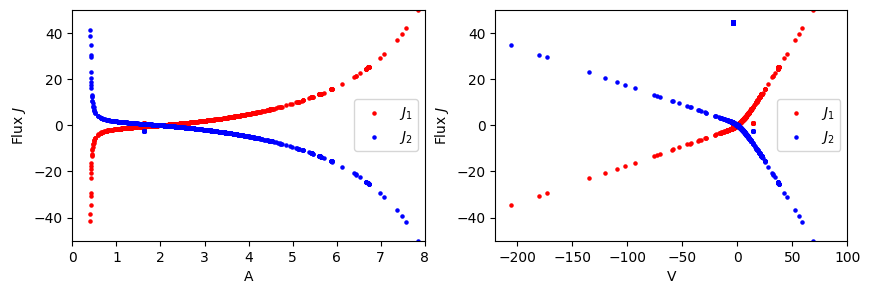

In [75]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(A_sol, J1, label='$J_1$',s=5, color='red')
axs[0, 0].scatter(A_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 0].set_xlabel('A')
axs[0, 0].set_ylabel('Flux $J$')
axs[0, 0].legend()
axs[0, 0].set_xlim(0, 8)  # Adjust the x-axis limits
axs[0, 0].set_ylim(-50, 50)  # Adjust the y-axis limits

axs[0, 1].scatter(V_sol, J1, label='$J_1$', s=5, color='red')
axs[0, 1].scatter(V_sol, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('Flux $J$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-220, 100)  # Adjust the x-axis limits
axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

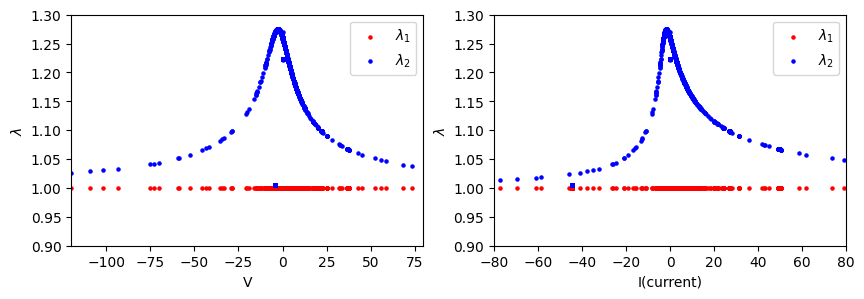

In [29]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

axs[0, 0].scatter(V_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 0].scatter(V_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('$\lambda$')
axs[0, 0].legend()
axs[0, 0].set_xlim(-120, 80)  # Adjust the x-axis limits
axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

axs[0, 1].scatter(I_sol, lmd1, label='$\lambda_1$', s=5, color='red')
axs[0, 1].scatter(I_sol, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('$\lambda$')
axs[0, 1].legend()
axs[0, 1].set_xlim(-80, 80)  # Adjust the x-axis limits
axs[0, 1].set_ylim(.9, 1.3)  # Adjust the y-axis limits
plt.show()